#**Imports**

In [2]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from torchvision.transforms.functional import to_pil_image
from torchvision import models, transforms

from fastai.callbacks import hook_outputs
from fastai.torch_core import requires_grad, children

In [3]:
torch.backends.cudnn.deterministic = True 
# check if training using GPU is possible
torch.cuda.is_available()

True

#**Downloading dataset from Kaggle to Google Drive**

In [4]:
# mounting Google Drive with your credentials 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# folder, created in advance in the Google Drive and containing kaggle.json
#project_folder = "/content/gdrive/My Drive/Kaggle/NaturalPainters" # for original email
project_folder = "/content/gdrive/My Drive/NaturalPainters" 
os.environ['KAGGLE_CONFIG_DIR'] = project_folder

In [7]:
# dive into folder
#%cd /content/gdrive/MyDrive/Kaggle/NaturalPainters
%cd /content/gdrive/MyDrive/NaturalPainters

/content/gdrive/.shortcut-targets-by-id/1m2LH2VheZ1KLU1PiFqOKItm5-sBWZ1C4/NaturalPainters


In [54]:
# path to save final generator weights
generator_path = project_folder + '/models/generator/generator_'

In [55]:
# download dataset from the given Kaggle page to the current folder
# !kaggle datasets download -d reiinakano/mypaint_brushstrokes

In [56]:
# data is currently dowloaded as a zip-folder, we need to unzip it
# !unzip \*.zip  && rm *.zip

In [57]:
SEED = 4

#**Show Dataset**

In [58]:
# data is stored in the 'episodes_i.npz' format, where i is in {0,...,77}
# this routine loads desired 'episodes_i.npz' for a particular i
# data will be loaded in the dictionary with two fields: 'strokes' and 'actions'
def load_data(npz):

    data = np.load('strokes-dataset/' + npz)
    return data['strokes'], data['actions']

In [59]:
# example 'episodes_i.npz' for i = 0, takes 196.3MB
current_npz = 'episodes_0.npz'

strokes, actions = load_data(current_npz)
print(f"Strokes are {strokes.shape[0]} images with img_width = {strokes.shape[1]}, img_height = {strokes.shape[2]} and n_channels = {strokes.shape[3]}")
print(f"Actions are {actions.shape[0]} arrays of dimension {actions.shape[1]}")

Strokes are 100000 images with img_width = 64, img_height = 64 and n_channels = 3
Actions are 100000 arrays of dimension 12


In [60]:
# printing routine for images in 'strokes' and corresponding numerical arrays in 'actions'
def print_data(strokes, 
               figsize = [12, 5], nrows = 2, ncols = 6,
               savepath = None):

    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)

    for i, ax in enumerate(axes.flat):
        img = strokes[i]
        ax.imshow(img)
        ax.set_title("Stroke " + str(i + 1))

    plt.tight_layout(True)

    if(savepath):
        plt.savefig(savepath, dpi = 200)
        print(f"Images were saved in {savepath}.")

    print(f"Example of {nrows*ncols} strokes:\n")
    plt.show()

Images were saved in /content/gdrive/My Drive/NaturalPainters/example_imgs.
Example of 12 strokes:



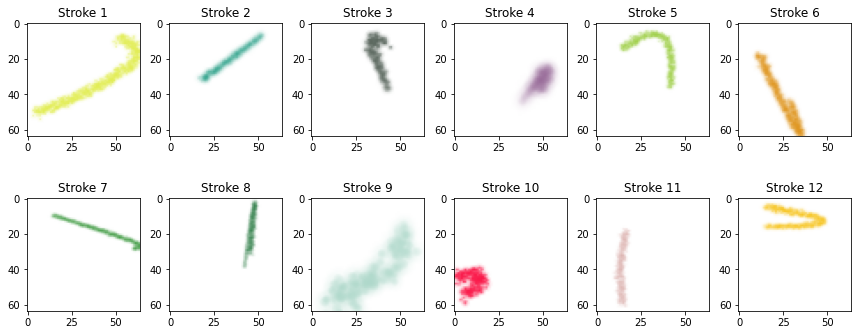

Example of 12 actions:

[[0.70163  0.30781  0.905674 0.382132 ... 0.327325 0.801232 0.132051 0.791512]
 [0.286395 0.565084 0.509936 0.343041 ... 0.463403 0.827277 0.10558  0.170216]
 [0.882056 0.469463 0.533015 0.174413 ... 0.358329 0.693955 0.602135 0.246814]
 [0.361594 0.893709 0.828945 0.408551 ... 0.560948 0.591296 0.712416 0.049876]
 ...
 [0.210662 0.909512 0.665188 0.632399 ... 0.783824 0.147759 0.905845 0.770463]
 [0.792833 0.392336 0.247886 0.700524 ... 0.280456 0.02041  0.702323 0.898893]
 [0.918944 0.082216 0.216768 0.610269 ... 0.695325 0.237305 0.939507 0.850217]
 [0.283974 0.291432 0.758155 0.204911 ... 0.078169 0.244963 0.080239 0.511231]]


In [61]:
# print first n_elem data samples
n_elem = 12
print_data(strokes[:n_elem], savepath = project_folder + "/example_imgs")
print(f"Example of {n_elem} actions:\n")
print(actions[:n_elem])

# **Generator**

In [62]:
class Generator(nn.Module):

    def __init__(self, 
                 in_features: int,
                 img_height: int,
                 img_width: int,
                 num_features: int,
                 img_channels: int):
      super(Generator, self).__init__()

      self.out_features = img_height * img_width

      self.lin = nn.Linear(in_features, self.out_features)

      self.conv1 = nn.ConvTranspose2d(self.out_features, num_features, 
                                      kernel_size = (4, 4), stride = (1, 1), bias = False)
      self.norm1 = nn.BatchNorm2d(num_features)

      self.conv2 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm2 = nn.BatchNorm2d(num_features)

      self.conv3 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm3 = nn.BatchNorm2d(num_features)

      self.conv4 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm4 = nn.BatchNorm2d(num_features)

      self.conv5 = nn.ConvTranspose2d(num_features, num_features, 
                                      kernel_size = (3, 3), stride = (1, 1), padding = (1, 1), bias = False)
      self.norm5 = nn.BatchNorm2d(num_features)

      self.conv6 = nn.ConvTranspose2d(num_features, img_channels, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)



    def forward(self, x):
      x = self.lin(x)
      x = F.relu(self.conv1(x.view(x.size(0), x.size(1), 1, 1)), inplace = True)
      x = self.norm1(x)
      x = F.relu(self.conv2(x), inplace = True)
      x = self.norm2(x)
      x = F.relu(self.conv3(x), inplace = True)
      x = self.norm3(x)
      x = F.relu(self.conv4(x), inplace = True)
      x = self.norm4(x)
      x = F.relu(self.conv5(x), inplace = True)
      x = self.norm5(x)

      return torch.tanh(self.conv6(x))

In [63]:
# to check created model
# generator = Generator(12, 64, 64, 512, 3)
# generator

In [64]:
# just to check on the output of the dataloader
# for (_, act) in dataloader:
#   print(act)
#   break
# generator(act)

In [65]:
# to see all vgg19_bn layers and indices of chosen for feature extraction ones
# extractor = models.vgg19_bn(True).features.cuda().eval()
# requires_grad(extractor, False)
# blocks = [i-1 for i,o in enumerate(children(extractor)) if isinstance(o, nn.MaxPool2d)]
# print(blocks, blocks[2:])

In [66]:
class FeatureExtractor(nn.Module):

    def __init__(self, 
                 layers_weights,
                 device):
      super(FeatureExtractor, self).__init__()
      
      self.layers_weights = layers_weights
      self.device = device
      self.feature_extractor, self.layers_indices = self.extractor()
      self.outputs = hook_outputs([self.feature_extractor[i] for i in self.layers_indices], detach = False)

    def extractor(self):
        print("Download VGG19 (batch normalized) as pre-trained.\n")
        if self.device == 'cuda':
            extractor = models.vgg19_bn(True).features.cuda().eval()
        else:
            extractor = models.vgg19_bn(True).features.eval()
        requires_grad(extractor, False)
        return extractor, [i - 1 for i, layer in enumerate(children(extractor)) if isinstance(layer, nn.MaxPool2d)][2:]

    def gram_matrix(self, input):

        (a, b, c, d) = input.size()
        features = input.view(a, b, c * d)
        G = features @ features.transpose(1, 2)
        return G.div(b * c * d)

    def forward(self, gen_stroke, true_stroke):

        self.feature_extractor(gen_stroke)
        gen_stroke_features = [out for out in self.outputs.stored]
        
        self.feature_extractor(true_stroke)
        true_stroke_features = [out.clone() for out in self.outputs.stored]

        self.loss = []
        
        feature_loss = [F.l1_loss(gen_layer, true_layer) * weight
                             for gen_layer, true_layer, weight 
                        in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]
        

        style_loss = [F.l1_loss(self.gram_matrix(gen_layer), self.gram_matrix(true_layer)) * weight**2 * 5000
                             for gen_layer, true_layer, weight 
                      in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]
    
        pixel_loss = [F.l1_loss(gen_stroke, true_stroke)]

        self.loss += feature_loss + style_loss + pixel_loss
                
        return sum(self.loss)

    def __del__(self):
        
        self.outputs.remove()

#**Training**

In [67]:
class Trainer():

    def __init__(self, 
                 transforms,
                 generator: nn.Module,
                 feature_extractor: nn.Module,
                 optimizer: torch.optim,
                 epochs: int = 5,
                 gpu: bool = False):
      super(Trainer, self).__init__()

      self.transforms = transforms
      self.generator = generator
      self.feature_extractor = feature_extractor
      self.optimizer = optimizer
      self.epochs = epochs
      self.gpu = gpu

    def train(self,
              dataloader,
              print_interval: int = 50,
              save_model_path = ''):

        print('-'*100)
        print('START OF TRAINING\n')
        for epoch in range(self.epochs):

            self.generator.train()

            epoch_loss = []
            epoch_gen_strokes = torch.ones_like(dataloader.sampler.data_source.tensors[0][0], dtype = torch.float32)

            for i, (stroke, action) in enumerate(dataloader):

                stroke = torch.stack([self.transforms(s) for s in stroke])

                if self.gpu:
                  action = action.cuda()
                  stroke = stroke.cuda()

                self.optimizer.zero_grad()

                gen_stroke = self.generator(action)
                cur_loss = self.feature_extractor(gen_stroke, stroke)
                cur_loss.backward()

                self.optimizer.step()

                epoch_loss.append(cur_loss.data.item())
                
                if (i % print_interval) == 0:
                    print('Epoch {}/{} | Sample {}/{}'.format((epoch + 1), self.epochs,
                                                                          (i + 1), len(dataloader)))
                    print(' => Loss: {:.3f}\n'.format(torch.mean(torch.FloatTensor(epoch_loss))))

                    print('true vs generated stroke:')
                    self.display_img(torch.cat((stroke[0].clone().cpu(), gen_stroke[0].clone().cpu()), dim = 2))

                    print('-'*50)

                    epoch_gen_strokes = torch.cat((epoch_gen_strokes.clone().cpu(), gen_stroke[0].clone().cpu()), dim = 2)

            print('-'*100)
            print('End of epoch {}'.format(epoch + 1))
            print('examples of generated during epoch strokes:')
            self.display_img(epoch_gen_strokes)
            print('-'*100)

        if save_model_path != '':
            torch.save(self.generator.state_dict(), save_model_path)
            print(f'\nEND OF TRAINING: model is saved to {save_model_path}')

    def display_img(self, img):
        display(to_pil_image(img))

Training is performed using GPU.

Download VGG19 (batch normalized) as pre-trained.

----------------------------------------------------------------------------------------------------
START OF TRAINING

Epoch 1/2 | Sample 1/391
 => Loss: 10.874

true vs generated stroke:


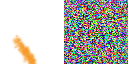

--------------------------------------------------
Epoch 1/2 | Sample 51/391
 => Loss: 7.931

true vs generated stroke:


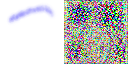

--------------------------------------------------
Epoch 1/2 | Sample 101/391
 => Loss: 7.258

true vs generated stroke:


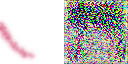

--------------------------------------------------
Epoch 1/2 | Sample 151/391
 => Loss: 6.813

true vs generated stroke:


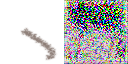

--------------------------------------------------
Epoch 1/2 | Sample 201/391
 => Loss: 6.464

true vs generated stroke:


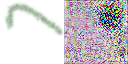

--------------------------------------------------
Epoch 1/2 | Sample 251/391
 => Loss: 6.200

true vs generated stroke:


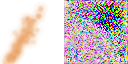

--------------------------------------------------
Epoch 1/2 | Sample 301/391
 => Loss: 5.981

true vs generated stroke:


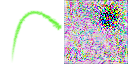

--------------------------------------------------
Epoch 1/2 | Sample 351/391
 => Loss: 5.807

true vs generated stroke:


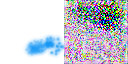

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 1
examples of generated during epoch strokes:


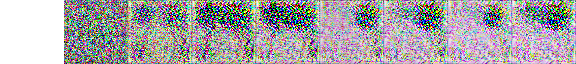

----------------------------------------------------------------------------------------------------
Epoch 2/2 | Sample 1/391
 => Loss: 4.533

true vs generated stroke:


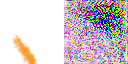

--------------------------------------------------
Epoch 2/2 | Sample 51/391
 => Loss: 4.504

true vs generated stroke:


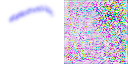

--------------------------------------------------
Epoch 2/2 | Sample 101/391
 => Loss: 4.441

true vs generated stroke:


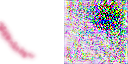

--------------------------------------------------
Epoch 2/2 | Sample 151/391
 => Loss: 4.383

true vs generated stroke:


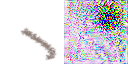

--------------------------------------------------
Epoch 2/2 | Sample 201/391
 => Loss: 4.331

true vs generated stroke:


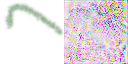

--------------------------------------------------
Epoch 2/2 | Sample 251/391
 => Loss: 4.281

true vs generated stroke:


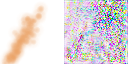

--------------------------------------------------
Epoch 2/2 | Sample 301/391
 => Loss: 4.228

true vs generated stroke:


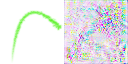

--------------------------------------------------
Epoch 2/2 | Sample 351/391
 => Loss: 4.173

true vs generated stroke:


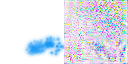

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 2
examples of generated during epoch strokes:


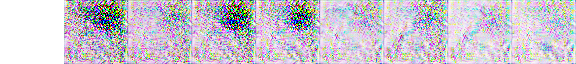

----------------------------------------------------------------------------------------------------

END OF TRAINING: model is saved to /content/gdrive/My Drive/NaturalPainters/models/generator/generator_5152w_2e_1d_new.pth


In [68]:
torch.manual_seed(SEED)
class Hparams():
    in_features = 12 #constant
    num_features = 512 #@param {type:"slider", min:8, max:1024, step:8}
    img_height = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_width = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_channels = 3 #@param {type:"slider", min:1, max:3, step:2}
    layers_weights = [5, 15, 2] #@param
    batch_size = 256 #@param {type: "slider", min:8, max:512, step:8}
    lr = 0.001 #@param {type:"number"}
    betas = (0.5, 0.9) #@param
    epochs = 2 #@param {type:"slider", min:1, max:1000, step:1}
    print_interval = 50 #@param {type:"slider", min:1, max:100, step:10}
hparams = Hparams()

gpu = torch.cuda.is_available()
if gpu:
    print("Training is performed using GPU.\n")
    device = 'cuda'
else:
    print("Training is performed using CPU.\n")
    device = 'cpu'

current_npz = 'episodes_1.npz'

strokes, actions = load_data(current_npz)

strokes = torch.stack([torch.from_numpy(stroke).permute(2, 0, 1) for stroke in strokes])
actions = torch.stack([torch.from_numpy(action).float() for action in actions])

dataset = TensorDataset(strokes, actions)

dataloader = DataLoader(dataset, 
                        batch_size = hparams.batch_size, 
                        shuffle = False)

generator = Generator(hparams.in_features,
                      hparams.img_height,
                      hparams.img_width,
                      hparams.num_features,
                      hparams.img_channels)

feature_extractor = FeatureExtractor(hparams.layers_weights, 
                                     device)
generator.to(device)

optimizer = optim.Adam(generator.parameters(), 
                       lr = hparams.lr, 
                       betas = hparams.betas)

strokes_tfms = transforms.Compose([transforms.Lambda(lambda x: 
                                                     x.float()),
                                   transforms.Lambda(lambda x: 
                                                     x.div_(255))
                                  ])

trainer = Trainer(strokes_tfms,
                  generator,
                  feature_extractor,
                  optimizer,
                  epochs = hparams.epochs,
                  gpu = gpu)

trainer.train(dataloader, 
              print_interval = hparams.print_interval,
              save_model_path = generator_path + 
              f'5152w_{hparams.epochs}e_1d_new.pth')

In [ ]:
#group print

In [ ]:
#save 

In [ ]:
#history

In [ ]:
#hparams

In [ ]:
#bigger images

In [ ]:
#some ideas from authors